In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



price_col = 'd_ln_price'
# price_col = 'd_ln_joules_per_coin'

results_df = None

data_loc = '../6_calculating_costs/monthly_stuff.csv'

def get_data(filter1: str, filter2: str, averages=3):

    # date,price,hashrate,coins_per_block,efficiency,max_efficiency,speculation,adoption,altcoins,none,posts_count,positive,neutral,negative,optimistic_speculation,pessimistic_speculation
    # 2023-10-01,27978.1,4.4106749777492784e+20,6.25,23880028945.454502,,0.877076411960133,0.2043938991771647,0.127359781121751,0.3427030670711156,0.1050545094152626,0.3953488372093023,0.4418604651162791,0.1627906976744186,0.8024068322981367,0.2088509316770186
    data = pd.read_csv(data_loc, parse_dates=['date'])


    # keep only data after filter
    data = data[data['date'] >= filter1]
    data = data[data['date'] < filter2]

    # time variable
    # data['time'] = 2+((data['date'].dt.year - 2010) * 12 + data['date'].dt.month -2)
    # data['ln_time'] = np.log(data['time'])
    # data['time_squared'] = data['time']**2

    # Create quarterly averages
    quarterly_data = data.resample('Q', on='date').mean()
    # Create monthly averages
    monthly_data = data.resample('M', on='date').mean()
    # Create weekly averages
    weekly_data = data.resample('W', on='date').mean()
    # Keep daily data
    daily_data = data

    useful_cols = data.columns[1:]

    # for df in [quarterly_data,monthly_data, weekly_data, daily_data]:
    # for df in [quarterly_data]:
    for df in [quarterly_data,monthly_data]:
        df["date"] = df.index
        df["before_asic"] = np.zeros(len(df))
        df["before_gpu"] = np.zeros(len(df))
        for i in range(len(df)):
            if df["date"].iloc[i] < pd.Timestamp('2013-07-01'):
                df["before_asic"].iloc[i] = 1
            if df["date"].iloc[i] < pd.Timestamp('2012-07-01'):
                df["before_gpu"].iloc[i] = 1

        for column in useful_cols:
            # df[f'ln_{column}'] = np.log(df[column])
            df[f'd_ln_{column}'] = np.log(df[column]).diff().fillna(method='bfill')
            df[f'avg_d_ln_{column}'] = df[f'd_ln_{column}']
        df['ln_price'] = np.log(df['price'])
            

        # to prevent the arima model from cheating the values have to be shifted
        # for column in df.columns:
        #     if column.startswith('d_') and column != 'd_ln_open_price':
        #         df[column] = df[column].shift(-1).fillna(method='ffill')

    
        # to prevent the arima model from cheating the values are replaced with the average of the last 3
        for column in useful_cols:
            column2 = f'd_ln_{column}'
            if column2 != price_col:
                # print(column2)
                for i in range(len(df)):
                    offset = min(i, averages)
                    newval = df[column2].iloc[i-offset:i].mean()
                    df['avg_' + column2].iloc[i] = newval if not np.isnan(newval) else 0

        # calculate a prediction for joules_per_coin using the average of the last 3 d_ln values of hashrate and efficiency
        # coins_per_block is trivial to predict and can be taken from the data

        # df['predicted_hashrate'] = np.exp(np.log(df['hashrate'].shift(-1)) + df['avg_d_ln_hashrate'])
        # df['predicted_efficiency'] = np.exp(np.log(df['efficiency'].shift(-1)) + df['avg_d_ln_efficiency'])
        # df['predicted_coins_per_block'] = df['coins_per_block']  # Assuming this is directly taken from the data
        # df['predicted_joules_per_coin'] = df['predicted_hashrate'] / (df['predicted_efficiency'] * df['predicted_coins_per_block'])
        # df['d_ln_predicted_joules_per_coin'] = np.log(df['predicted_joules_per_coin']).diff().fillna(method='bfill')

        df['predicted_hashrate'] = np.zeros(len(df))
        df['predicted_efficiency'] = np.zeros(len(df))
        df['predicted_coins_per_block'] = np.zeros(len(df))
        df['predicted_joules_per_coin'] = np.zeros(len(df))
        df['d_ln_predicted_joules_per_coin'] = np.zeros(len(df))
        for i in range(len(df)):
            # for the first value, we give the model the real value instead of a prediction
            if i == 0:
                df['predicted_hashrate'].iloc[i] = df['hashrate'].iloc[i]
                df['predicted_efficiency'].iloc[i] = df['efficiency'].iloc[i]
                df['predicted_coins_per_block'].iloc[i] = df['coins_per_block'].iloc[i]
                df['predicted_joules_per_coin'].iloc[i] = df['hashrate'].iloc[i] / (df['efficiency'].iloc[i] * df['coins_per_block'].iloc[i])
            else:
                df['predicted_hashrate'].iloc[i] = np.exp(np.log(df['hashrate'].iloc[i-1]) + df['avg_d_ln_hashrate'].iloc[i])
                df['predicted_efficiency'].iloc[i] = np.exp(np.log(df['efficiency'].iloc[i-1]) + df['avg_d_ln_efficiency'].iloc[i])
                df['predicted_coins_per_block'].iloc[i] = df['coins_per_block'].iloc[i]
                df['predicted_joules_per_coin'].iloc[i] = df['predicted_hashrate'].iloc[i] / (df['predicted_efficiency'].iloc[i] * df['predicted_coins_per_block'].iloc[i])

        df['d_ln_predicted_joules_per_coin'] = np.log(df['predicted_joules_per_coin']).diff().fillna(method='bfill')

        df['real_joules_per_coin'] = df['hashrate'] / (df['efficiency'] * df['coins_per_block'])
        df['ln_real_joules_per_coin'] = np.log(df['real_joules_per_coin'])
        df['d_ln_joules_per_coin'] = np.log(df['real_joules_per_coin']).diff().fillna(method='bfill')

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method='bfill', inplace=True)

        # to_scale = []
        # for column in df.columns:
        #     if column.startswith('d_') and column != price_col:
        #         to_scale.append(column)
        # for column in to_scale:
        #     scaler = MinMaxScaler()
        #     df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))


    return quarterly_data,monthly_data, weekly_data, daily_data







def plot_model(test_data, predictions, p, q, title='Model Estimation'):
    # Normalizing count and d_ln_avg_efficiency
    # scaler = MinMaxScaler(feature_range=(-0.15, 0.15))
    # normalized_values = scaler.fit_transform(test_data[['count', 'd_ln_avg_efficiency', 'cost', 'open_price', 'd_ln_cost', 'd_ln_joules_per_coin']])
    # normalized_count = normalized_values[:, 0]
    # normalized_d_ln_avg_efficiency = normalized_values[:, 1]
    # normalized_cost = normalized_values[:, 2]
    # normalized_open_price = normalized_values[:, 3]
    # normalized_d_ln_cost = normalized_values[:, 4]
    # normalized_d_ln_joules_per_coin = normalized_values[:, 5]

    offset = -9 if price_col == 'ln_open_price' else 0
    
    # Plotting the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data.index, test_data[price_col]+offset, label=f'Actual {price_col}', color='blue', marker='o')
    plt.scatter(test_data.index, predictions+offset, label=f'Predicted {price_col}', color='red', marker='x')
    # plt.plot(test_data.index, normalized_count, label='Normalized Count', color='green', linestyle='--')
    # plt.plot(test_data.index, normalized_d_ln_joules_per_coin, label='Normalized normalized_d_ln_joules_per_coin', color='green', linestyle='--')
    # plt.plot(test_data.index, normalized_d_ln_avg_efficiency, label='Normalized d_ln_avg_efficiency', color='purple', linestyle='-.')
    # plt.plot(test_data.index, normalized_d_ln_cost, label='Normalized d_ln_cost', color='purple', linestyle='-.')
    # plt.plot(test_data.index, normalized_cost, label='Normalized Cost', color='orange', linestyle=':')
    # plt.plot(test_data.index, normalized_open_price, label='Normalized Open Price', color='black', linestyle='-.')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
    plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
    plt.xlabel('Date')
    plt.ylabel('diff of ln(open price) and Normalized Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

def add_constant(train_exog, test_exog):
    # train_exog["const"] = 1
    # test_exog["const"] = 1
    # # Ensure the shapes of train_exog and test_exog match
    # print(train_exog.columns)
    # print(test_exog.columns)
    return train_exog, test_exog

def residuals_tests(model_fit):
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Test residuals for autocorrelation, normality, and heteroscedasticity
    residuals = model_fit.resid
    # Autocorrelation tests
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    durbin_watson = sm.stats.durbin_watson(residuals)
    # Normality tests
    jarque_bera = sm.stats.jarque_bera(residuals)
    shapiro_wilk = shapiro(residuals)
    # Heteroscedasticity test
    white_test = [-1,-1]
    try:
        white_test = sm.stats.het_white(residuals, model_fit.model.exog)
    except Exception as e:
        pass
    
    res = {
        'AIC': aic, 'BIC': bic,
        'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
        'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
        'White Test': white_test[1]
    }
    for k, v in res.items():
        print(k + ": " + str(v)[:(5 if k not in ['White Test'] else 9)])

loss_table = []
# Adjust the model estimation to use the differenced series
def model_estimation(data, p_range, q_range, exog_cols, use_exog, title='Model Estimation', eval_size=8, noprint=False):
    global results_df
    global loss_table 


    results = []
    data_size = len(data)
    train_size = data_size - eval_size

    loss_table = []

    for p in p_range:
        for q in q_range:
            try:
                # Perform rolling cross-validation
                rolling_mae = []
                rolling_mse = []
                mean_baseline_mae = []
                mean_baseline_mse = []
                prev_value_baseline_mae = []
                prev_value_baseline_mse = []
                step_size = 1
                summary = ""
                all_predictions = []
                for end in range(train_size, data_size, step_size):  # Adjust these values as needed
                    # print(f"p: {p}, q: {q}, end: {end}")
                    rolling_train = data.iloc[0:end]
                    rolling_test = data.iloc[end:end + step_size]  # Predict one step ahead
                    rolling_train_exog, rolling_test_exog = add_constant(rolling_train[exog_cols], rolling_test[exog_cols])
                    
                    # Baseline 1: Mean Prediction
                    mean_pred = np.mean(rolling_train[price_col])
                    mean_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [mean_pred]*step_size))
                    mean_baseline_mse.append(mean_squared_error(rolling_test[price_col], [mean_pred]*step_size))
                    
                    # Baseline 2: Previous Value Prediction
                    prev_value_pred = rolling_train[price_col].iloc[-1]
                    prev_value_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [prev_value_pred]*step_size))
                    prev_value_baseline_mse.append(mean_squared_error(rolling_test[price_col], [prev_value_pred]*step_size))


                    # ARIMA Model
                    if use_exog:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q), exog=rolling_train_exog)
                    else:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q))
                    model_fit = model.fit()
                    
                    summary = model_fit.summary()
                    if use_exog:
                        predictions = model_fit.forecast(steps=step_size, exog=rolling_test_exog)
                    else:
                        predictions = model_fit.forecast(steps=step_size)
                    mae = mean_absolute_error(rolling_test[price_col], predictions)
                    mse = mean_squared_error(rolling_test[price_col], predictions)
                    rolling_mae.append(mae)
                    rolling_mse.append(mse)
                    all_predictions.extend(predictions)
                
                # print("rolling_mse")
                # print(rolling_mse)
                avg_mae = np.mean(rolling_mae)
                avg_mse = np.mean(rolling_mse)
                avg_mean_baseline_mae = np.mean(mean_baseline_mae)
                avg_mean_baseline_mse = np.mean(mean_baseline_mse)
                avg_prev_value_baseline_mae = np.mean(prev_value_baseline_mae)
                avg_prev_value_baseline_mse = np.mean(prev_value_baseline_mse)
                results.append({'p': p, 'q': q, 'MAE': avg_mae, 'Mean Baseline MAE': avg_mean_baseline_mae, 'Prev Value Baseline MAE': avg_prev_value_baseline_mae, 'MSE': avg_mse, 'Mean Baseline MSE': avg_mean_baseline_mse, 'Prev Value Baseline MSE': avg_prev_value_baseline_mse,'Summary': summary,'all_predictions':all_predictions})

                loss_table.append({"p":p,"q":q,"MSE":avg_mse,"MAE":avg_mae})

            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")
                if noprint:
                    return 9999

    if noprint:
        return results[0]['MSE']

    # sort results and print/plot only the top 3
    results = sorted(results, key=lambda x: x['MSE'])
    print(f"Mean Baseline MSE: {results[0]['Mean Baseline MSE']}")
    print(f"Previous Value Baseline MSE: {results[0]['Prev Value Baseline MSE']}")
    for i in range(3):
        p = results[i]['p']
        q = results[i]['q']
        
        # Fit the model on the entire training dataset
        model_fit = None
        if use_exog:
            train_exog, _ = add_constant(data[exog_cols], [])
            train_exog = np.array(train_exog)
            model = ARIMA(data[price_col], order=(p, 0, q), exog=train_exog)
            model_fit = model.fit()
        else:
            model = ARIMA(data[price_col], order=(p, 0, q))
            model_fit = model.fit()

        print(f"Top {i+1} Model: ARIMA({p},0,{q})")
        residuals_tests(model_fit)
        print("MSE:",results[i]['MSE'])
        print(results[i]['Summary'])

        train_data = data.iloc[0:train_size]
        test_data = data.iloc[train_size:]

        all_predictions = results[i]['all_predictions']
        all_predictions_with_dates = pd.Series(all_predictions, index=test_data.index)
              
        # plot_model(test_data, predictions, p, q, title=f"{title} - Top {i+1} Model")
        plot_model(test_data, all_predictions_with_dates, p, q, title=f"{title} - Top {i+1} Model")



In [37]:

def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    cols = [price_col,'d_ln_joules_per_coin'] #'d_ln_avg_efficiency', 
    numeric_df = df[cols]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # rename count to "amount of values"
    summary.rename(columns={'count': 'amount of values'}, inplace=True)
    # print(summary)

    for col in cols:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=10, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=10, ax=axes[1])
            plt.show()

    return summary


def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    # if result[1] > 0.05:
    #     print("Series is not stationary")
    # else:
    #     print("Series is stationary")


from statsmodels.tsa.stattools import coint
def perform_cointegration_test(df, column1, column2):
    """
    Perform the co-integration test on two specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: The name of the first column to test.
    - column2: The name of the second column to test.

    Returns:
    - coint_t: The t-statistic of the test.
    - p_value: The p-value of the test.
    - crit_value: Critical values for the test.
    """
    score, p_value, crit_value = coint(df[column1], df[column2])
    print(f"Co-integration test results for {column1} and {column2}:")
    print(f"t-statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical values: {crit_value}")
    if p_value < 0.05:
        print("The series are likely co-integrated.")
    else:
        print("The series are not likely co-integrated.")
    print("")
    # return score, p_value, crit_value


def cross_correlation(series1, series2, lag=10, plot=True):
    """
    Calculate and plot cross-correlation between two series.
    
    Parameters:
    - series1: First time series.
    - series2: Second time series.
    - lag: Number of lags to calculate cross-correlation for.
    - plot: Whether to plot the cross-correlation values.
    
    Returns:
    - Cross-correlation values.
    """
    cc_values = [series1.corr(series2.shift(l)) for l in range(-lag, lag+1)]
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.stem(range(-lag, lag+1), cc_values)#, use_line_collection=True)
        plt.xlabel('Lag')
        plt.ylabel('Cross-correlation')
        plt.title('Cross-correlation between series')
        plt.show()
    
    return cc_values

In [38]:
# quarterly_data, monthly_data, weekly_data, daily_data = get_data('2010-12-31', '9999-01-01',2)
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2011-12-31', '9999-01-01',2)
# quarterly_data, monthly_data, weekly_data, daily_data = get_data('2005-12-31', '9999-01-01',2)

In [39]:
# quarterly_data.tail(10)
quarterly_data.head(10)
# quarterly_data

,price,hashrate,coins_per_block,efficiency,max_efficiency,speculation,adoption,altcoins,none,posts_count,positive,neutral,negative,optimistic_speculation,pessimistic_speculation,date,before_asic,before_gpu,d_ln_price,avg_d_ln_price,d_ln_hashrate,avg_d_ln_hashrate,d_ln_coins_per_block,avg_d_ln_coins_per_block,d_ln_efficiency,avg_d_ln_efficiency,d_ln_max_efficiency,avg_d_ln_max_efficiency,d_ln_speculation,avg_d_ln_speculation,d_ln_adoption,avg_d_ln_adoption,d_ln_altcoins,avg_d_ln_altcoins,d_ln_none,avg_d_ln_none,d_ln_posts_count,avg_d_ln_posts_count,d_ln_positive,avg_d_ln_positive,d_ln_neutral,avg_d_ln_neutral,d_ln_negative,avg_d_ln_negative,d_ln_optimistic_speculation,avg_d_ln_optimistic_speculation,d_ln_pessimistic_speculation,avg_d_ln_pessimistic_speculation,ln_price,predicted_hashrate,predicted_efficiency,predicted_coins_per_block,predicted_joules_per_coin,d_ln_predicted_joules_per_coin,real_joules_per_coin,ln_real_joules_per_coin,d_ln_joules_per_coin
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-03-31,5.421533,1.044500e+13,32.5,3.438895e+06,0.000023,0.194046,0.398502,0.108240,0.647208,0.102246,0.275735,0.608554,0.115711,0.091108,0.080515,2012-03-31,1.0,1.0,-0.074177,-0.074177,0.113437,0.000000,-0.262364,0.000000,0.181085,0.000000,0.000000,0.000000,-0.965518,0.000000,0.067558,0.000000,-0.524961,0.000000,0.101745,0.000000,0.034924,0.000000,0.133011,0.000000,-0.028476,0.000000,-0.212398,0.000000,-0.141227,0.000000,-2.026277,0.000000,1.690379,1.044500e+13,3.438895e+06,32.5,9.345579e+04,0.194716,9.345579e+04,11.445244,0.194716
2012-06-30,5.033933,1.169967e+13,25.0,4.121574e+06,0.000023,0.073890,0.426354,0.064033,0.716525,0.105880,0.314961,0.591470,0.093569,0.079108,0.010614,2012-06-30,1.0,1.0,-0.074177,-0.074177,0.113437,0.113437,-0.262364,-0.262364,0.181085,0.181085,0.000000,0.000000,-0.965518,-0.965518,0.067558,0.067558,-0.524961,-0.524961,0.101745,0.101745,0.034924,0.034924,0.133011,0.133011,-0.028476,-0.028476,-0.212398,-0.212398,-0.141227,-0.141227,-2.026277,-2.026277,1.616202,1.169967e+13,4.121574e+06,25.0,1.135456e+05,0.194716,1.135456e+05,11.639960,0.194716
2012-09-30,8.714900,1.745152e+13,25.0,4.435690e+06,0.000023,0.150208,0.361191,0.000000,0.753793,0.103898,0.253447,0.625748,0.120805,0.079903,0.057903,2012-09-30,1.0,0.0,0.548833,0.548833,0.399866,0.113437,0.000000,-0.262364,0.073448,0.181085,0.000000,0.000000,0.709440,-0.965518,-0.165864,0.067558,-1.801294,-0.524961,0.050704,0.101745,-0.018898,0.034924,-0.217297,0.133011,0.056338,-0.028476,0.255480,-0.212398,0.009998,-0.141227,1.696606,-2.026277,2.165034,1.310505e+13,4.939777e+06,25.0,1.061185e+05,-0.067648,1.573736e+05,11.966378,0.326418
2012-12-31,11.844000,2.319758e+13,25.0,4.657044e+06,0.000127,0.099556,0.427036,0.064894,0.694087,0.065246,0.344633,0.553020,0.102347,0.042879,0.016982,2012-12-31,1.0,0.0,0.306787,0.306787,0.284621,0.256652,0.000000,-0.131182,0.048698,0.127266,1.692377,0.000000,-0.411300,-0.128039,0.167461,-0.049153,-1.801294,0.000000,-0.082520,0.076225,-0.465245,0.008013,0.307327,-0.042143,-0.123554,0.013931,-0.165809,0.021541,-0.622440,-0.065615,-1.226602,-0.164836,2.471821,2.255773e+13,5.037700e+06,25.0,1.791114e+05,0.523451,1.992472e+05,12.202302,0.235924
2013-03-31,22.767700,3.153333e+13,25.0,6.370522e+07,0.001078,0.229392,0.506266,0.010713,0.486496,0.129006,0.360474,0.558988,0.080538,0.152243,0.057447,2013-03-31,1.0,0.0,0.653521,0.653521,0.306997,0.342244,0.000000,0.000000,2.615886,0.061073,2.141992,0.846189,0.834710,0.149070,0.170195,0.000799,-1.801294,0.000000,-0.355370,-0.015908,0.681689,-0.242072,0.044939,0.045015,0.010735,-0.033608,-0.239644,0.044835,1.267098,-0.306221,1.218689,0.235002,3.125343,3.266459e+13,4.950327e+06,25.0,2.639388e+05,0.387709,1.979953e+04,9.893413,-2.308888
2013-06-30,116.763333,1.016067e+14,25.0,2.264226e+08,0.001250,0.234810,0.397054,0.180671,0.602715,0.280311,0.280987,0.601468,0.117546,0.146693,0.129610,2013-06-30,1.0,0.0,1.634806,1.634806,1.170064,0.295809,0.000000,0.000000,1.268137,1.332292,0.

In [40]:
# for col in quarterly_data.columns:
#     if col.startswith('avg'):
#         print(f"# '{col}',")s

In [41]:

# # find best start date
# dates = pd.read_csv(data_loc, parse_dates=['date']).resample('Q', on='date').mean().index
# dates = dates[:33]
# best_mse = 999999
# best_date = None
# best_averaging = None
# for date in dates:
#     print(date)
#     for averaging in [2,3]:
#         print(averaging)
#         quarterly_data, monthly_data, weekly_data, daily_data = get_data(date, '9999-01-01',averaging)
#         all_mse = []
#         for cols in [[],['d_ln_joules_per_coin'],['avg_d_ln_pessimistic_speculation']]:
#             mse = model_estimation(quarterly_data, range(1, 2, 1), range(1, 2, 1), cols, True, title='Quarterly Data', eval_size=13, noprint=True)
#             all_mse.append(mse)
#         print(np.mean(all_mse))
#         if np.mean(all_mse) < best_mse:
#             best_mse = np.mean(all_mse)
#             best_date = date
#             best_averaging = averaging

# print("")
# print(best_date)
# print(best_mse)
# print(best_averaging)
    

In [42]:
# d = monthly_data[["price","real_joules_per_coin"]]
# d["date"] = d.index
# d.to_csv("monthly_price_joules.csv",index=False)

# Quaterly

Quarterly Data Model Estimation:
Mean Baseline MSE: 0.14882992355086158
Previous Value Baseline MSE: 0.18142630067621338
Top 1 Model: ARIMA(1,0,1)
AIC: 59.49
BIC: 68.85
Ljung-Box: 0.388
Durbin-Watson: 1.984
Jarque-Bera: 0.036
Shapiro-Wilk: 0.019
White Test: 0.1910900
MSE: 0.12525710710091292
                               SARIMAX Results                                
Dep. Variable:             d_ln_price   No. Observations:                   47
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -24.684
Date:                Thu, 09 May 2024   AIC                             59.368
Time:                        22:07:38   BIC                             68.619
Sample:                    03-31-2012   HQIC                            62.849
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.

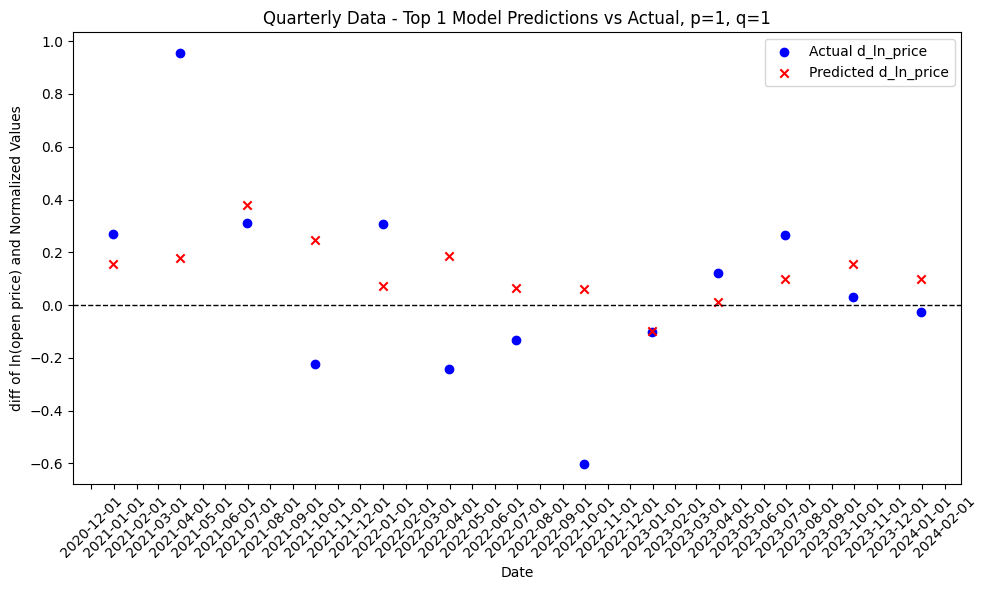

IndexError: list index out of range

In [44]:
exog_cols = [
'before_asic',
# 'before_gpu',

# 'd_ln_price',

# 'avg_efficiency',
# 'avg_d_ln_max_efficiency',
# 'avg_d_ln_count',
# 'avg_d_ln_cost_per_coin',
# 'avg_d_ln_watts',
# 'avg_d_ln_joules_per_dollar_earned',
# 'avg_d_ln_optimistic_speculation',

# 'd_ln_predicted_joules_per_coin',
# 'd_ln_joules_per_coin',

# 'avg_d_ln_adoption',

# 'avg_d_ln_hashrate',
# 'avg_d_ln_efficiency',
# 'd_ln_efficiency',

# 'd_ln_pessimistic_speculation',

# 'avg_d_ln_pessimistic_speculation',
# 'avg_d_ln_speculation',
# 'avg_d_ln_posts_count',
# 'avg_d_ln_positive',
# 'avg_d_ln_neutral',
# 'avg_d_ln_negative',

# 'time',
# 'ln_time',
# 'time_squared',
]
# Baseline 3: no exog
# use_exog = False
use_exog = True

print("Quarterly Data Model Estimation:")
# model_estimation(quarterly_data, range(1, 4, 1), range(1, 4, 1), exog_cols, use_exog, title='Quarterly Data', eval_size=13)
model_estimation(quarterly_data, range(1, 2, 1), range(1, 2, 1), exog_cols, use_exog, title='Quarterly Data', eval_size=13)
results_df

In [ ]:
loss_table_df = pd.DataFrame(loss_table)
loss_table_df

,p,q,MSE,MAE
0,1,1,0.118867,0.249578
1,1,2,0.196636,0.355914
2,1,3,0.172929,0.343180
3,2,1,0.110351,0.236741
4,2,2,0.206273,0.366680
5,2,3,0.166300,0.330360
6,3,1,0.137260,0.258364
7,3,2,0.254230,0.398338
8,3,3,0.155071,0.314034


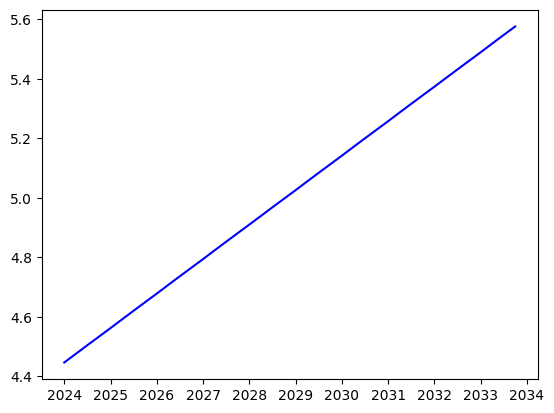

In [ ]:
# # obtain long term forecast
# exog = quarterly_data[cols]
# model = ARIMA(quarterly_data[price_col], order=(1, 0, 1), exog=exog).fit()
# # repeat the average of the last 10 rows for 10 years
# exog2 = pd.DataFrame()
# for column in cols:
#     exog2[column] = [quarterly_data[column].iloc[-10:].mean()]*40
# # print(exog2)
# preds = model.forecast(steps=40, exog=exog2)
# # print(preds)

# # plot the predicted price
# plt.figure(figsize=(10, 6))
# dates = pd.date_range(start=quarterly_data.index[-1], end='2033-11-01', freq='Q')

# last_price = quarterly_data["price"].iloc[-1]
# ln_prices = np.log(last_price) + preds.cumsum()
# prices = np.exp(ln_prices)
# log10_prices = np.log10(prices)

# plt.plot(dates, log10_prices, label='Predicted Price', color='red')



# obtain long term forecast with koomey's law
last_price = quarterly_data["price"].iloc[-1]
time_to_double = 2.6
koomey_preds = []
for i in range(40):
    koomey_preds.append(last_price * 2**((i/4)/time_to_double))
dates = pd.date_range(start=quarterly_data.index[-1], end='2033-11-01', freq='Q')
plt.plot(dates, np.log10(koomey_preds), label='Koomey Prediction', color='blue')

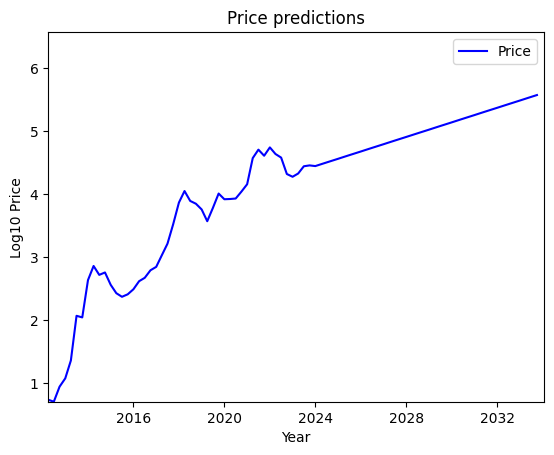

In [ ]:
# create plot with old data and prediction
# concat the x axis
old_x = quarterly_data.index
new_x = dates
all_x = np.concatenate([old_x,new_x])
# concat the y axis
old_y = np.log10(quarterly_data["price"])
new_y = np.log10(koomey_preds)
all_y = np.concatenate([old_y,new_y])

plt.plot(all_x, all_y, label='Price', color='blue')

# Get current axes
ax = plt.gca()

# Extend the limits of x and y axes
ax.set_xlim([min(all_x), max(all_x) + 9999999999999999])  # Extend x-axis to the right
ax.set_ylim([min(all_y), max(all_y) + 1])  # Extend y-axis upwards

# Add labels and title if necessary
plt.xlabel('Year')
plt.ylabel('Log10 Price')
plt.title('Price predictions')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
first = koomey_preds[0]
last = koomey_preds[-1]

print("percentage increase:",100*(last-first)/first)

In [ ]:
print(f"Stationarity check for ln_price:")
check_stationarity(quarterly_data["ln_price"])
print(f"Stationarity check for d_ln_price:")
check_stationarity(quarterly_data["d_ln_price"])
print("\nStationarity check for ln_real_joules_per_coin:")
check_stationarity(quarterly_data['ln_real_joules_per_coin'])
print("\nStationarity check for d_ln_joules_per_coin:")
check_stationarity(quarterly_data['d_ln_joules_per_coin'])
print("\nStationarity check for avg_d_ln_pessimistic_speculation:")
check_stationarity(quarterly_data['avg_d_ln_pessimistic_speculation'])

Stationarity check for ln_price:
ADF Statistic: -2.636031
p-value: 0.085777
Stationarity check for d_ln_price:
ADF Statistic: -5.098261
p-value: 0.000014

Stationarity check for ln_real_joules_per_coin:
ADF Statistic: -3.412257
p-value: 0.010548

Stationarity check for d_ln_joules_per_coin:
ADF Statistic: -4.219189
p-value: 0.000611

Stationarity check for avg_d_ln_pessimistic_speculation:
ADF Statistic: -3.252159
p-value: 0.017157


Distribution Plot:


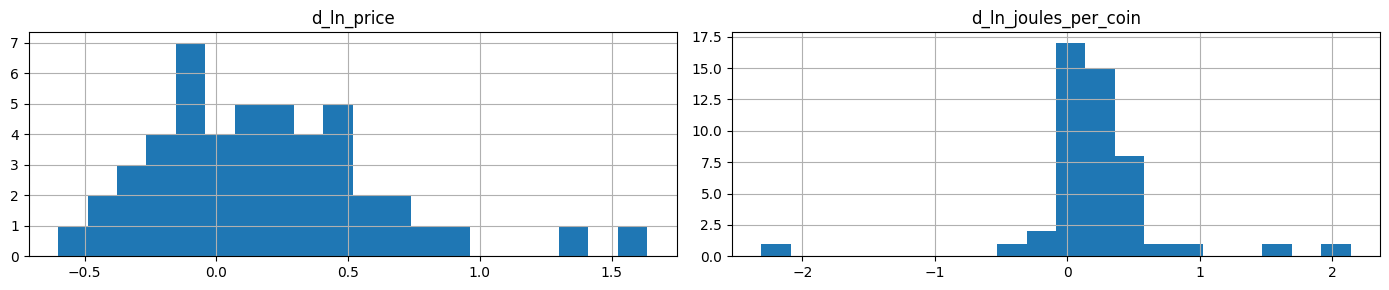

Summary Statistics:
ACF and PACF Plots for d_ln_price:


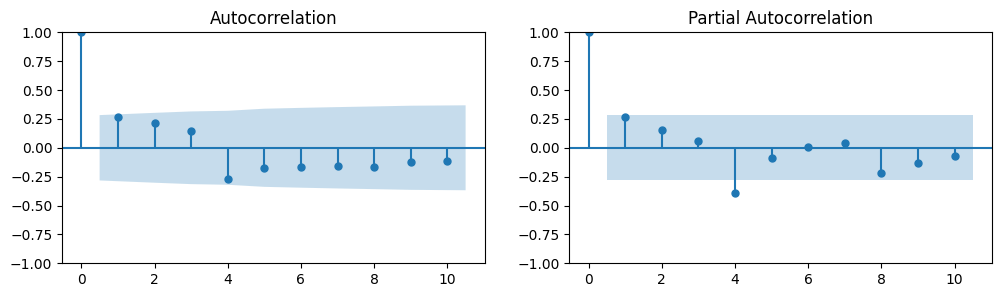

ACF and PACF Plots for d_ln_joules_per_coin:


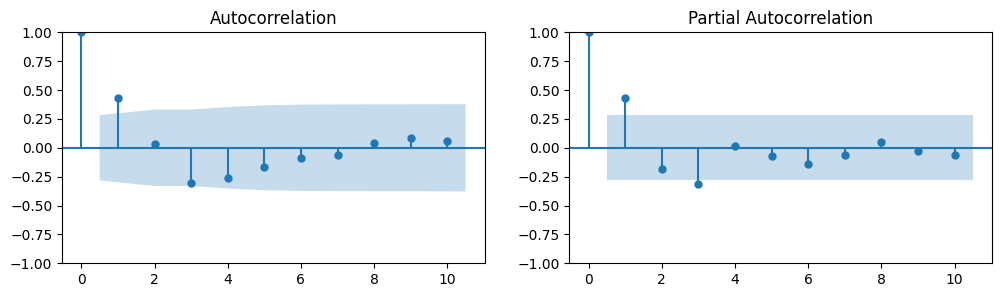

,amount of values,mean,std,min,25%,50%,75%,max,skewness,kurtosis
d_ln_price,48.0,0.176555,0.443244,-0.600618,-0.110369,0.122221,0.422576,1.634806,1.073665,1.958933
d_ln_joules_per_coin,48.0,0.219923,0.556304,-2.308888,0.050646,0.198661,0.345757,2.140258,-0.776838,11.713576


In [ ]:
exploratory_analysis(quarterly_data)

In [ ]:
perform_cointegration_test(quarterly_data, price_col, 'd_ln_price')
perform_cointegration_test(quarterly_data, price_col, 'd_ln_joules_per_coin')

Co-integration test results for d_ln_price and d_ln_price:
t-statistic: -inf
p-value: 0.0
Critical values: [-4.1446366  -3.46922086 -3.13591962]
The series are likely co-integrated.

Co-integration test results for d_ln_price and d_ln_joules_per_coin:
t-statistic: -5.053887429423385
p-value: 0.00013089817345419085
Critical values: [-4.1446366  -3.46922086 -3.13591962]
The series are likely co-integrated.



In [ ]:
# cross_correlation_values = cross_correlation(quarterly_data['d_ln_avg_efficiency'], quarterly_data[price_col], lag=10)

In [ ]:
# cross_correlation_values = cross_correlation(quarterly_data['d_ln_joules_per_coin'], quarterly_data['d_ln_price'], lag=10)
cross_correlation_values = cross_correlation(quarterly_data['d_ln_price'], quarterly_data['d_ln_joules_per_coin'], lag=10)

In [ ]:
cross_correlation_values = cross_correlation(quarterly_data['d_ln_efficiency'], quarterly_data['d_ln_price'], lag=10)

# Monthly

In [ ]:
print("Monthly Data Model Estimation:")
model_estimation(monthly_data, range(1, 6, 1), range(1, 6, 1), title='Monthly Data', eval_size=12)
results_df

In [ ]:
exploratory_analysis(monthly_data)

# Weekly

In [ ]:
print("Weekly Data Model Estimation:")
model_estimation(weekly_data, range(1, 6, 1), range(1, 6, 1), title='Weekly Data', eval_size=55)
# model_estimation(weekly_data, range(1, 4, 1), range(1, 3, 1), title='Weekly Data', ratio=0.8)
results_df

In [ ]:
exploratory_analysis(weekly_data)

# Daily

In [ ]:
# print("Daily Data Model Estimation:")
# # model_estimation(daily_data, range(1, 6, 1), range(1, 6, 1), title='Daily Data', ratio=0.8)
# model_estimation(daily_data, range(1, 3, 1), range(1, 3, 1), title='Daily Data', ratio=0.8)

In [ ]:
exploratory_analysis(daily_data)